# Label-free classification using IDEAS features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scip_workflows.common import *

In [3]:
import seaborn
import fcsparser
from sklearn.preprocessing import scale
from scipy.stats import pearsonr, spearmanr
from scip_workflows import core

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

import pickle

In [13]:
plt.rcParams['figure.dpi'] = 200

# Data

In [4]:
try:
    features = snakemake.input.features
    labels = snakemake.input.labels
    hpo_cyto = snakemake.input.hpo_cyto
    output_confmat = snakemake.output.confmat
    output_metrics = snakemake.output.metrics
except NameError:
    data_dir = Path("/home/maximl/scratch/data/vsc/datasets/wbc/ideas/")
    features = data_dir / "WBC_ideas_features.parquet"
    labels = data_dir / "labels.parquet"
    hpo_cyto = data_dir / "hpo" / "WBC_rsh_ideas_cyto_li_xgboost.pickle"
    output_confmat = data_dir / "figures" / "WBC_ideas_cv_confmat.png"
    output_metrics = data_dir / "figures" / "WBC_ideas_cv_metrics.png"

In [5]:
df = pq.read_table(features).to_pandas()
labels = pq.read_table(labels).to_pandas()
df = df.merge(labels, left_index=True, right_index=True)

In [6]:
r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df.columns))
df = df.drop(columns=todrop)
df.shape

(274050, 306)

# HPO results

In [7]:
with open(hpo_cyto, "rb") as fh:
    grid = pickle.load(fh)

/srv/scratch/maximl/mambaforge/envs/scip/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator HalvingRandomSearchCV from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
grid["test_balanced_accuracy"].mean(), scipy.stats.sem(grid["test_balanced_accuracy"])

(0.8527125927325537, 0.0022640421768951946)

In [9]:
grid["test_balanced_accuracy"], grid["train_balanced_accuracy"]

(array([0.85927836, 0.85052361, 0.85577535, 0.84602947, 0.85195618]),
 array([0.91989679, 0.92425271, 0.91915127, 0.90348899, 0.917719  ]))

# Classification

In [10]:
enc = LabelEncoder().fit(df["meta_label"])
y = enc.transform(df["meta_label"])

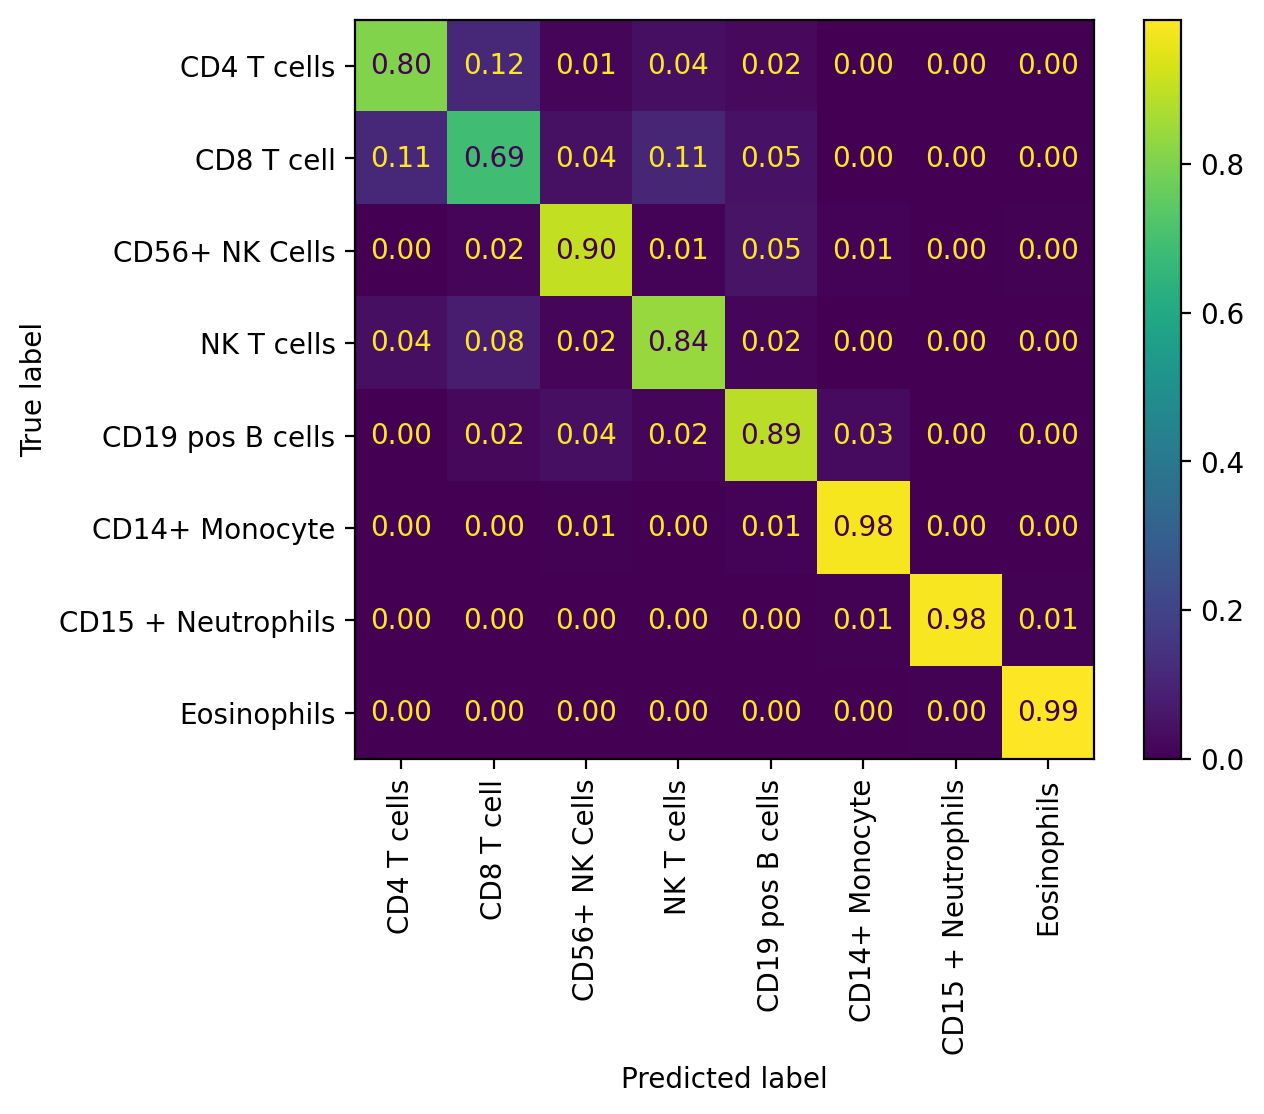

In [14]:
X = df.filter(regex="(bf420nm480nm|bf570nm595nm|m01|m06|m09|ssc)$").drop(2, level="meta_group").drop('late', level="meta_fix")

y = enc.transform(df.drop(2, level="meta_group").drop('late', level="meta_fix")["meta_label"])
preds = []
true = []

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
for estimator, (_, test_index) in zip(grid["estimator"], skf.split(X, y)):
    X_test, y_test = X.iloc[test_index], y[test_index]
    preds.extend(estimator.predict(X_test))    
    true.extend(y_test)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(
    true, preds, 
    labels=[3, 5, 4, 7, 2, 0, 1, 6],
    display_labels=enc.classes_[[3, 5, 4, 7, 2, 0, 1, 6]],
    normalize='true', xticks_rotation="vertical", values_format=".2f",
    ax=ax
)
plt.savefig(output_confmat, bbox_inches="tight")